In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.plot
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

# Step 0: Paths and stuff - Argparse

In [3]:
basedir = '/media/guille/DADES/DADES/Delineator'
model_name = 'WNet5BoundLoss_20201026000000'
valid_folds = sak.load_data(os.path.join(basedir,'TrainedModels',model_name,'validation_files.csv'),dtype=None)

In [4]:
# Convert valid folds to opposite map
fold_of_file = {fname: k for k in valid_folds for fname in valid_folds[k]}

# Step 1: Load models

In [6]:
models = {}

for i in range(5):
    models['fold_{}'.format(i+1)] = torch.load(os.path.join(basedir,'TrainedModels',model_name,'fold_{}'.format(i+1),'model_best.model'),pickle_module=dill).eval().float()

# Step 2: Predict databases

### 1.1. QTDB

In [7]:
dataset = pd.read_csv(os.path.join(basedir,'QTDB','Dataset.csv'), index_col=0)
dataset = dataset.sort_index(axis=1)
validity = sak.load_data(os.path.join(basedir, 'QTDB', 'validity.csv'))

Pon    = sak.load_data(os.path.join(basedir, 'QTDB', 'PonNew.csv'))
Poff   = sak.load_data(os.path.join(basedir, 'QTDB', 'PoffNew.csv'))
QRSon  = sak.load_data(os.path.join(basedir, 'QTDB', 'QRSonNew.csv'))
QRSoff = sak.load_data(os.path.join(basedir, 'QTDB', 'QRSoffNew.csv'))
Ton    = sak.load_data(os.path.join(basedir, 'QTDB', 'TonNew.csv'))
Toff   = sak.load_data(os.path.join(basedir, 'QTDB', 'ToffNew.csv'))

In [8]:
dataset2 = {}
predictions = {}
batch_size = 16
window_size = 2**11
stride = window_size//(2**2)

for i,(sig_name,signal) in enumerate(tqdm.tqdm(dataset.iteritems(),total=dataset.shape[1])):
    # Retrieve signal name and fold
    fname = sig_name.split('_')[0]
    if fname not in fold_of_file:
        continue
    fold = fold_of_file[fname]
    
    if fname in ['sel35','sel36','sel103','sel232','sel310']: continue
        
    # Copy signal just in case
    signal = np.copy(signal.values)
    
    # Filter signal
    signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250., 'high'),signal.T).T
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 125.0/250.,  'low'),signal.T).T

    # Normalize and pad signal for inputing in algorithm
    pad_size = math.ceil(signal.size/window_size)*window_size - signal.size
    signal = np.pad(signal, (0,pad_size), mode='edge')
    normalization = np.median(sak.signal.moving_lambda(signal,256,sak.signal.abs_max))
    normalized_signal = signal/normalization
    
    # Window signal for meeting the input size
    windowed_signal = (skimage.util.view_as_windows(normalized_signal, window_size, stride) - 0)[:,None,:]
    windowed_mask  = torch.zeros((windowed_signal.shape[0],3,window_size),dtype=float)
    
    # Predict masks
    with torch.no_grad():
        for i in range(0,windowed_signal.shape[0],batch_size):
            inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).cuda().float()}
            windowed_mask[i:i+batch_size] = models[fold].cuda()(inputs)["sigmoid"]
            # windowed_mask[i:i+batch_size] = models[fold].cuda()(torch.tensor(windowed_signal[i:i+batch_size]).cuda().float())[0]
            models[fold] = models[fold].cpu()
    windowed_mask = np.round(windowed_mask.cpu().detach().numpy()).astype(int)

    # Retrieve mask as 1D
    counter = np.zeros_like(signal, dtype=int)
    signal_mask = np.zeros((3,signal.size))

    for i in range(windowed_mask.shape[0]):
        counter[i*stride:i*stride+window_size] += 1
        signal_mask[:,i*stride:i*stride+window_size] += windowed_mask[i]
    signal_mask = (signal_mask/counter) > 0.5
    
    # Opening/closing operations
    signal_mask[0,:] = cv2.morphologyEx(signal_mask[0,:].astype(float), cv2.MORPH_CLOSE, np.ones((25,))).squeeze().astype(bool)
    signal_mask[1,:] = cv2.morphologyEx(signal_mask[1,:].astype(float), cv2.MORPH_CLOSE, np.ones((25,))).squeeze().astype(bool)
    signal_mask[2,:] = cv2.morphologyEx(signal_mask[2,:].astype(float), cv2.MORPH_CLOSE, np.ones((25,))).squeeze().astype(bool)

    signal_mask[0,:] = cv2.morphologyEx(signal_mask[0,:].astype(float), cv2.MORPH_OPEN, np.ones((5,))).squeeze().astype(bool)
    signal_mask[1,:] = cv2.morphologyEx(signal_mask[1,:].astype(float), cv2.MORPH_OPEN, np.ones((5,))).squeeze().astype(bool)
    signal_mask[2,:] = cv2.morphologyEx(signal_mask[2,:].astype(float), cv2.MORPH_OPEN, np.ones((5,))).squeeze().astype(bool)

    # Store prediction
    dataset2[sig_name] = normalized_signal
    predictions[sig_name] = signal_mask

100%|██████████| 210/210 [03:39<00:00,  1.05s/it]


In [9]:
# Retrieve onsets and offsets
pon, poff, qrson, qrsoff, ton, toff = {},{},{},{},{},{}

for k in tqdm.tqdm(predictions):
    pon[k],poff[k]     = sak.signal.get_mask_boundary(predictions[k][0,],aslist=False)
    qrson[k],qrsoff[k] = sak.signal.get_mask_boundary(predictions[k][1,],aslist=False)
    ton[k],toff[k]     = sak.signal.get_mask_boundary(predictions[k][2,],aslist=False)

    # Refine results
    val_on = validity[k][0::2].tolist()
    val_off = validity[k][1::2].tolist()
    
    # P wave
    joint_on = []
    joint_off = []
    for v_on,v_off in zip(val_on,val_off):
        tmp_on, tmp_off = src.metrics.filter_valid(pon[k],poff[k],v_on,v_off)
        joint_on.append(tmp_on)
        joint_off.append(tmp_off)
    pon[k],poff[k] = np.concatenate(joint_on),np.concatenate(joint_off)
    
    # QRS wave
    joint_on = []
    joint_off = []
    for v_on,v_off in zip(val_on,val_off):
        tmp_on, tmp_off = src.metrics.filter_valid(qrson[k],qrsoff[k],v_on,v_off)
        joint_on.append(tmp_on)
        joint_off.append(tmp_off)
    qrson[k],qrsoff[k] = np.concatenate(joint_on),np.concatenate(joint_off)
    
    # T wave
    joint_on = []
    joint_off = []
    for v_on,v_off in zip(val_on,val_off):
        tmp_on, tmp_off = src.metrics.filter_valid(ton[k],toff[k],v_on,v_off)
        joint_on.append(tmp_on)
        joint_off.append(tmp_off)
    ton[k],toff[k] = np.concatenate(joint_on),np.concatenate(joint_off)
    
    

100%|██████████| 200/200 [00:00<00:00, 336.86it/s]


# Single and Multi-lead metrics

In [10]:
metrics_single = {}

for wave in ['p','qrs','t']:
    metrics_single[wave] = {}
    metrics_single[wave]['truepositives'] = {}
    metrics_single[wave]['falsepositives'] = {}
    metrics_single[wave]['falsenegatives'] = {}
    metrics_single[wave]['onerrors'] = {}
    metrics_single[wave]['offerrors'] = {}

    input_on   = eval('{}on'.format(wave.lower()))
    input_off  = eval('{}off'.format(wave.lower()))
    target_on  = eval('{}on'.format(wave.upper()))
    target_off = eval('{}off'.format(wave.upper()))
    
    # Compute metrics_single
    for k in input_on:
        if fname in ['sel35','sel36','sel103','sel232','sel310']: continue
        try:
            # Refine input and output's regions w/ validity vectors
            (input_on[k],input_off[k]) = src.metrics.filter_valid(input_on[k],input_off[k], validity[k][0], validity[k][1])
            (target_on[k],target_off[k]) = src.metrics.filter_valid(target_on[k],target_off[k], validity[k][0], validity[k][1])
            tp,fp,fn,dice,onerror,offerror = src.metrics.compute_metrics(input_on[k],input_off[k],target_on[k],target_off[k])
        except:
            continue
        metrics_single[wave]['truepositives'][k] = tp
        metrics_single[wave]['falsepositives'][k] = fp
        metrics_single[wave]['falsenegatives'][k] = fn
        metrics_single[wave]['onerrors'][k] = np.copy(np.array(onerror))
        metrics_single[wave]['offerrors'][k] = np.copy(np.array(offerror))

        
print("# {}".format(model_name))

print("\n--- SINGLE ---\n")

for wave in ['p','qrs','t']:
    print("######### {} wave #########".format(wave.upper()))
    print("")
    print("Precision:    {}%".format(np.round(src.metrics.precision(sum(metrics_single[wave]['truepositives'].values()),sum(metrics_single[wave]['falsepositives'].values()),sum(metrics_single[wave]['falsenegatives'].values()))*100,decimals=2)))
    print("Recall:       {}%".format(np.round(src.metrics.recall(sum(metrics_single[wave]['truepositives'].values()),sum(metrics_single[wave]['falsepositives'].values()),sum(metrics_single[wave]['falsenegatives'].values()))*100,decimals=2)))
    print("F1 score:     {}%".format(np.round(src.metrics.f1_score(sum(metrics_single[wave]['truepositives'].values()),sum(metrics_single[wave]['falsepositives'].values()),sum(metrics_single[wave]['falsenegatives'].values()))*100,decimals=2)))
    print("")
    print("Onset Error:  {} ± {} ms".format(np.round(np.mean([v for l in metrics_single[wave]['onerrors'].values() for v in l])/250*1000,decimals=2),np.round(np.std([v for l in metrics_single[wave]['onerrors'].values() for v in l])/250*1000,decimals=2)))
    print("Offset Error: {} ± {} ms".format(np.round(np.mean([v for l in metrics_single[wave]['offerrors'].values() for v in l])/250*1000,decimals=2),np.round(np.std([v for l in metrics_single[wave]['offerrors'].values() for v in l])/250*1000,decimals=2)))
    print("\n")
    
print("---")

print("\n--- MULTI ---\n")

metrics_multi = {}

for wave in ['p','qrs','t']:
    metrics_multi[wave] = {}
    metrics_multi[wave]['truepositives'] = {}
    metrics_multi[wave]['falsepositives'] = {}
    metrics_multi[wave]['falsenegatives'] = {}
    metrics_multi[wave]['onerrors'] = {}
    metrics_multi[wave]['offerrors'] = {}

    input_on   = eval('{}on'.format(wave.lower()))
    input_off  = eval('{}off'.format(wave.lower()))
    target_on  = eval('{}on'.format(wave.upper()))
    target_off = eval('{}off'.format(wave.upper()))

    listkeys = [k.split('_')[0] for k in input_on]

    for k in listkeys:
        if k in ['sel35','sel36','sel103','sel232','sel310']: continue
        try:
            # Refine input and output's regions w/ validity vectors
            (input_on[k+'_0'],input_off[k+'_0']) = src.metrics.filter_valid(input_on[k+'_0'],input_off[k+'_0'], validity[k+'_0'][0], validity[k+'_0'][1])
            (target_on[k+'_0'],target_off[k+'_0']) = src.metrics.filter_valid(target_on[k+'_0'],target_off[k+'_0'], validity[k+'_0'][0], validity[k+'_0'][1])
            (input_on[k+'_1'],input_off[k+'_1']) = src.metrics.filter_valid(input_on[k+'_1'],input_off[k+'_1'], validity[k+'_1'][0], validity[k+'_1'][1])
            (target_on[k+'_1'],target_off[k+'_1']) = src.metrics.filter_valid(target_on[k+'_1'],target_off[k+'_1'], validity[k+'_1'][0], validity[k+'_1'][1])
            tp,fp,fn,dice,on,off = src.metrics.compute_QTDB_metrics(input_on[k+'_0'],input_off[k+'_0'],
                                                                    input_on[k+'_1'],input_off[k+'_1'],
                                                                    target_on[k+'_0'],target_off[k+'_0'])
        except:
            continue
        metrics_multi[wave]['truepositives'][k] = tp
        metrics_multi[wave]['falsepositives'][k] = fp
        metrics_multi[wave]['falsenegatives'][k] = fn
        metrics_multi[wave]['onerrors'][k] = on
        metrics_multi[wave]['offerrors'][k] = off

for wave in ['p','qrs','t']:
    print("######### {} wave #########".format(wave.upper()))
    print("")
    print("Precision:    {}%".format(np.round(src.metrics.precision(sum(metrics_multi[wave]['truepositives'].values()),sum(metrics_multi[wave]['falsepositives'].values()),sum(metrics_multi[wave]['falsenegatives'].values()))*100,decimals=2)))
    print("Recall:       {}%".format(np.round(src.metrics.recall(sum(metrics_multi[wave]['truepositives'].values()),sum(metrics_multi[wave]['falsepositives'].values()),sum(metrics_multi[wave]['falsenegatives'].values()))*100,decimals=2)))
    print("F1 score:     {}%".format(np.round(src.metrics.f1_score(sum(metrics_multi[wave]['truepositives'].values()),sum(metrics_multi[wave]['falsepositives'].values()),sum(metrics_multi[wave]['falsenegatives'].values()))*100,decimals=2)))
    print("")
    print("Onset Error:  {} ± {} ms".format(np.round(np.mean([v for l in metrics_multi[wave]['onerrors'].values() for v in l])/250*1000,decimals=2),np.round(np.std([v for l in metrics_multi[wave]['onerrors'].values() for v in l])/250*1000,decimals=2)))
    print("Offset Error: {} ± {} ms".format(np.round(np.mean([v for l in metrics_multi[wave]['offerrors'].values() for v in l])/250*1000,decimals=2),np.round(np.std([v for l in metrics_multi[wave]['offerrors'].values() for v in l])/250*1000,decimals=2)))
    print("\n")

# WNet5BoundLoss_20201026000000

--- SINGLE ---

######### P wave #########

Precision:    98.94%
Recall:       97.02%
F1 score:     97.97%

Onset Error:  -4.44 ± 21.47 ms
Offset Error: 1.48 ± 15.99 ms


######### QRS wave #########

Precision:    99.54%
Recall:       99.97%
F1 score:     99.75%

Onset Error:  -1.46 ± 11.54 ms
Offset Error: 5.77 ± 13.91 ms


######### T wave #########

Precision:    99.54%
Recall:       99.66%
F1 score:     99.6%

Onset Error:  1.47 ± 41.39 ms
Offset Error: 16.89 ± 55.18 ms


---

--- MULTI ---

######### P wave #########

Precision:    98.48%
Recall:       98.24%
F1 score:     98.36%

Onset Error:  -3.34 ± 17.58 ms
Offset Error: -0.28 ± 10.79 ms


######### QRS wave #########

Precision:    99.36%
Recall:       100.0%
F1 score:     99.68%

Onset Error:  -0.8 ± 7.85 ms
Offset Error: 2.59 ± 7.95 ms


######### T wave #########

Precision:    99.33%
Recall:       99.84%
F1 score:     99.59%

Onset Error:  2.72 ± 34.8 ms
Offset Error: 13.21 ± 46.47 ms




In [162]:
wave = 't'
metric = 'offerrors'
comparison = lambda x: np.std(x)*4 < 15
tmp = {k: metrics[wave][metric][k] for k in metrics[wave][metric] if comparison(metrics[wave][metric][k])}
tmplist = list(tmp)
# tmp

sele0411


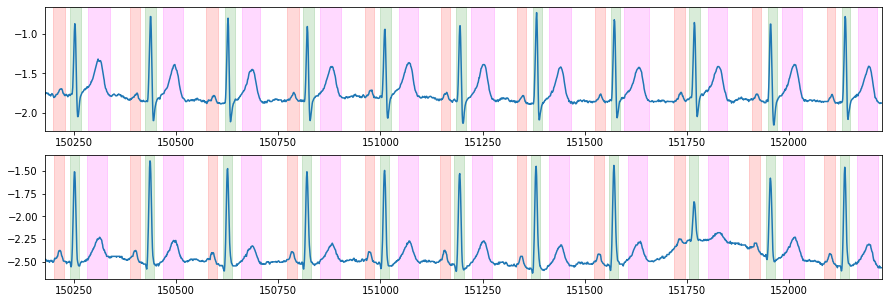

In [161]:
# k = 'sel46_1'
# k = 'sele0116_1'
# k = 'sel30_1'
k = tmplist[63]
print(k)

k1 = k.split('_')[0] + '_0'
k2 = k.split('_')[0] + '_1'
w = 0*2048+0
v_on = validity[k1][0]
f,ax = plt.subplots(nrows=2,figsize=(15,5))
ax[0].plot(dataset[k1][v_on+w:v_on+2048+w])
ax[1].plot(dataset[k2][v_on+w:v_on+2048+w])
# True
if k1 in Pon: [ax[0].axvspan(on,off,color='red',alpha=0.15) for on,off in zip(Pon[k1],Poff[k1])]
[ax[0].axvspan(on,off,color='green',alpha=0.15) for on,off in zip(QRSon[k1],QRSoff[k1])]
[ax[0].axvspan(on,off,color='magenta',alpha=0.15) for on,off in zip(Ton[k1],Toff[k1])]
# Predicted
if k2 in pon: [ax[1].axvspan(on,off,color='red',alpha=0.15) for on,off in zip(pon[k2],poff[k2])]
[ax[1].axvspan(on,off,color='green',alpha=0.15) for on,off in zip(qrson[k2],qrsoff[k2])]
[ax[1].axvspan(on,off,color='magenta',alpha=0.15) for on,off in zip(ton[k2],toff[k2])]

# [ax[i].axvline(154820,color='red') for i in range(2)]
[ax[i].set_xlim([v_on+w,v_on+2048+w]) for i in range(2)]
plt.show()

# Multi5All_20201009184921

--- SINGLE ---

######### P wave #########

Precision:    98.07%
Recall:       96.14%
F1 score:     97.09%

Onset Error:  -2.66 ± 20.65 ms
Offset Error: -1.19 ± 17.92 ms


######### QRS wave #########

Precision:    99.58%
Recall:       99.7%
F1 score:     99.64%

Onset Error:  -1.25 ± 11.77 ms
Offset Error: 6.35 ± 16.96 ms


######### T wave #########

Precision:    98.88%
Recall:       98.5%
F1 score:     98.69%

Onset Error:  0.59 ± 37.92 ms
Offset Error: 6.85 ± 56.09 ms

---
--- MULTI ---

######### P wave #########

Precision:    97.44%
Recall:       97.6%
F1 score:     97.52%

Onset Error:  -2.09 ± 16.84 ms
Offset Error: -1.53 ± 11.23 ms


######### QRS wave #########

Precision:    99.44%
Recall:       99.97%
F1 score:     99.7%

Onset Error:  -0.54 ± 8.09 ms
Offset Error: 3.27 ± 10.59 ms


######### T wave #########

Precision:    97.16%
Recall:       99.29%
F1 score:     98.21%

Onset Error:  1.66 ± 35.72 ms
Offset Error: 7.06 ± 46.0 ms


# Multi5All_20201016205331 (+real data)

--- SINGLE ---

######### P wave #########

Precision:    98.48%
Recall:       95.84%
F1 score:     97.14%

Onset Error:  -0.09 ± 19.02 ms
Offset Error: 2.12 ± 15.21 ms


######### QRS wave #########

Precision:    99.55%
Recall:       99.91%
F1 score:     99.73%

Onset Error:  0.64 ± 11.19 ms
Offset Error: 4.46 ± 15.92 ms


######### T wave #########

Precision:    98.5%
Recall:       99.36%
F1 score:     98.92%

Onset Error:  0.53 ± 40.02 ms
Offset Error: 5.73 ± 52.0 ms

---
--- MULTI ---

######### P wave #########

Precision:    97.88%
Recall:       97.0%
F1 score:     97.44%

Onset Error:  0.16 ± 13.18 ms
Offset Error: 0.8 ± 9.59 ms


######### QRS wave #########

Precision:    99.44%
Recall:       99.97%
F1 score:     99.7%

Onset Error:  0.74 ± 7.61 ms
Offset Error: 2.59 ± 11.76 ms


######### T wave #########

Precision:    96.55%
Recall:       99.35%
F1 score:     97.93%

Onset Error:  0.7 ± 37.42 ms
Offset Error: 7.49 ± 42.41 ms


# ~W-Net~

~--- SINGLE ---~

~######### P wave #########~

~Precision:    98.91%~
~Recall:       75.29%~
~F1 score:     85.5%~

~Onset Error:  -1.1 ± 22.6 ms~
~Offset Error: -1.18 ± 16.21 ms~


~######### QRS wave #########~

~Precision:    99.63%~
~Recall:       99.9%~
~F1 score:     99.77%~

~Onset Error:  -0.55 ± 11.86 ms~
~Offset Error: 4.47 ± 15.64 ms~


~######### T wave #########~

~Precision:    99.65%~
~Recall:       99.55%~
~F1 score:     99.6%~

~Onset Error:  10.67 ± 43.55 ms~
~Offset Error: -1.59 ± 56.99 ms~


---

~--- MULTI ---~


~######### P wave #########~

~Precision:    98.45%~
~Recall:       76.71%~
~F1 score:     86.23%~

~Onset Error:  -1.01 ± 17.87 ms~
~Offset Error: -1.86 ± 10.73 ms~


~######### QRS wave #########~

~Precision:    99.55%~
~Recall:       99.94%~
~F1 score:     99.74%~

~Onset Error:  -0.02 ± 8.18 ms~
~Offset Error: 1.99 ± 10.13 ms~


~######### T wave #########~

~Precision:    99.49%~
~Recall:       99.9%~
~F1 score:     99.7%~

~Onset Error:  8.8 ± 34.68 ms~
~Offset Error: 0.5 ± 44.54 ms~

# WNet5BoundLoss_20201026000000 [BEST]

_**OLD DEFINITION OF INSTANCE LOSS, WITH MSELoss AND 0.05 WEIGHT**_

--- SINGLE ---

######### P wave #########

Precision:    98.94%
Recall:       97.02%
F1 score:     97.97%

Onset Error:  -4.44 ± 21.47 ms
Offset Error: 1.48 ± 15.99 ms


######### QRS wave #########

Precision:    99.54%
Recall:       99.97%
F1 score:     99.75%

Onset Error:  -1.46 ± 11.54 ms
Offset Error: 5.77 ± 13.91 ms


######### T wave #########

Precision:    99.54%
Recall:       99.66%
F1 score:     99.6%

Onset Error:  1.47 ± 41.39 ms
Offset Error: 16.89 ± 55.18 ms

---

--- MULTI ---

######### P wave #########

Precision:    98.94%
Recall:       97.02%
F1 score:     97.97%

Onset Error:  -4.44 ± 21.47 ms
Offset Error: 1.48 ± 15.99 ms


######### QRS wave #########

Precision:    99.54%
Recall:       99.97%
F1 score:     99.75%

Onset Error:  -1.46 ± 11.54 ms
Offset Error: 5.77 ± 13.91 ms


######### T wave #########

Precision:    99.54%
Recall:       99.66%
F1 score:     99.6%

Onset Error:  1.47 ± 41.39 ms
Offset Error: 16.89 ± 55.18 ms

# ~WNet5SelfAttention_20201029000000~

~--- SINGLE ---~

~######### P wave #########~

~Precision:    98.73%~
~Recall:       98.24%~
~F1 score:     98.49%~

~Onset Error:  -1.71 ± 18.17 ms~
~Offset Error: 3.4 ± 15.73 ms~


~######### QRS wave #########~

~Precision:    94.14%~
~Recall:       92.59%~
~F1 score:     93.36%~

~Onset Error:  98.71 ± 690.75 ms~
~Offset Error: -90.38 ± 663.52 ms~


~######### T wave #########~

~Precision:    99.6%~
~Recall:       99.87%~
~F1 score:     99.74%~

~Onset Error:  2.93 ± 39.29 ms~
~Offset Error: 8.85 ± 45.71 ms~

---

~--- MULTI ---~

~######### P wave #########~

~Precision:    98.29%~
~Recall:       98.96%~
~F1 score:     98.62%~

~Onset Error:  -1.38 ± 13.27 ms~
~Offset Error: 0.96 ± 10.69 ms~


~######### QRS wave #########~

~Precision:    95.73%~
~Recall:       94.83%~
~F1 score:     95.28%~

~Onset Error:  97.41 ± 701.0 ms~
~Offset Error: -81.38 ± 638.24 ms~


~######### T wave #########~

~Precision:    99.43%~
~Recall:       100.0%~
~F1 score:     99.71%~

~Onset Error:  4.21 ± 31.22 ms~
~Offset Error: 6.6 ± 34.49 ms~

# WNetSelfAttention5F1InstanceLoss_20201102

--- SINGLE ---

######### P wave #########

Precision:    98.87%
Recall:       94.94%
F1 score:     96.87%

Onset Error:  -10.33 ± 25.01 ms
Offset Error: 0.49 ± 19.34 ms


######### QRS wave #########

Precision:    99.09%
Recall:       99.97%
F1 score:     99.53%

Onset Error:  -0.03 ± 13.37 ms
Offset Error: 5.33 ± 16.52 ms


######### T wave #########

Precision:    98.89%
Recall:       99.55%
F1 score:     99.22%

Onset Error:  -7.31 ± 40.72 ms
Offset Error: 18.72 ± 52.46 ms

----

--- MULTI ---

######### P wave #########

Precision:    98.21%
Recall:       96.51%
F1 score:     97.35%

Onset Error:  -8.85 ± 22.48 ms
Offset Error: -0.73 ± 15.11 ms


######### QRS wave #########

Precision:    98.51%
Recall:       100.0%
F1 score:     99.25%

Onset Error:  -0.03 ± 9.93 ms
Offset Error: 2.95 ± 11.56 ms


######### T wave #########

Precision:    98.36%
Recall:       99.81%
F1 score:     99.08%

Onset Error:  -5.67 ± 35.74 ms
Offset Error: 15.59 ± 44.7 ms

# Step 3: Compute metrics

# DICOM

In [14]:
import pydicom

def predict_mask(signal, N, stride, model, ptg_voting = 0.25):
    total_samples = np.zeros((1,),dtype='int64')
    
    # Data structure for computing the segmentation
    windowed_signal = np.array([(skimage.util.view_as_windows((signal)[:,lead],N,stride)) for lead in range(signal.shape[1])])[:,:,None,:]
    windowed_sample = np.array((skimage.util.view_as_windows(np.arange(signal.shape[0]),N,stride)))

    segmentation = np.zeros((3,signal.shape[0]),dtype=int)
    samples_voting = np.zeros((signal.shape[0],),dtype=int)

    # Compute segmentation for all leads independently
    for lead in range(windowed_signal.shape[0]):
        for i in range(0,windowed_signal.shape[1]):
            with torch.no_grad():
                prediction = predict_segment(model,windowed_signal[lead,i,None,...]) > thr_dice

            # Fused segmentation
            segmentation[:,windowed_sample[i]] += prediction
            samples_voting[windowed_sample[i]] += 1

    # Keep track of number of samples predicted
    total_samples += samples_voting.sum()

    # Majority voting according to number of times windowed and computed
    segmentation = (segmentation > (samples_voting*ptg_voting).astype(int))
    
    return segmentation


In [15]:
dicom = pydicom.dcmread('../../PediatricEchoHitachi/input/AG183834/F3QKAC02')
ecg = dicom[(0x7fe1,  0x1001)][0][(0x7fe1, 0x1010)][2][(0x7fe1, 0x1020)][0][(0x7fe1, 0x103a)][0]
vals = []
ecgValue = ecg[(0x7fe1, 0x1069)].value
for i in range(len(ecg[(0x7fe1, 0x1069)].value)//2):

    val = (256) * ecgValue[2*i + 1] +  ecgValue[2*i]
    if ecgValue[2*i + 1] >=128: #Two's complement
        val -= 2**16
    vals.append(val)

ecg = np.array(vals, dtype=float)
ecg = sak.signal.on_off_correction(ecg)
ecg = sak.data.ball_scaling(ecg,metric=sak.signal.abs_max)
ecg = sp.interpolate.interp1d(np.linspace(0,1,ecg.size),ecg)(np.linspace(0,1,ecg.size//3))

In [16]:
model = []
for i in range(5):
    model.append(torch.load(os.path.join(basedir,'TrainedModels',model_name,'fold_{}'.format(i+1),'model_best.model'),pickle_module=dill).eval().float())

In [17]:
# Obtain segmentation
tensor_ecg = torch.tensor(ecg)[None,None,].float().cuda()
with torch.no_grad():
    for i,m in enumerate(model):
        if i == 0:
            segmentation = m(tensor_ecg)[0].cpu().numpy().astype(int)
        else:
            segmentation += m(tensor_ecg)[0].cpu().numpy().astype(int)

    segmentation = segmentation >= 3
segmentation = segmentation[0,]

In [18]:
pon,poff = sak.signal.get_mask_boundary(segmentation[0,:])
qrson,qrsoff = sak.signal.get_mask_boundary(segmentation[1,:])
ton,toff = sak.signal.get_mask_boundary(segmentation[2,:])

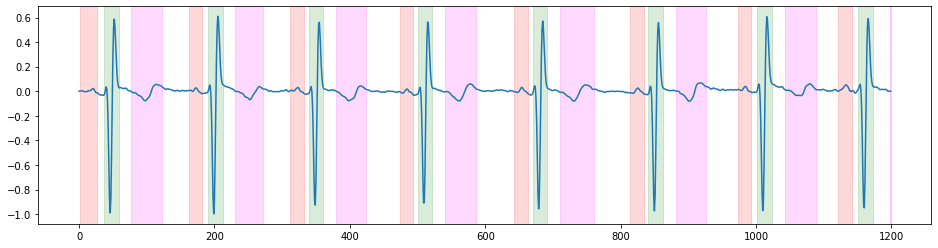

In [21]:
plt.figure(figsize=(16,4))
plt.plot(ecg)
ax = plt.gca()
[ax.axvspan(on,off,color='red',alpha=0.15) for on,off in zip(pon,poff)]
[ax.axvspan(on,off,color='green',alpha=0.15) for on,off in zip(qrson,qrsoff)]
[ax.axvspan(on,off,color='magenta',alpha=0.15) for on,off in zip(ton,toff)]

In [43]:
ecg.size

3600

# OLD AND CREEPY

In [11]:
# amplitudes = {}
# sizes = {}

# for k in QRSon:
#     for i,(on,off) in enumerate(zip(QRSon[k],QRSoff[k])):
#         if k in dataset2:
#             amplitudes[k+'###{}'.format(i)] = sak.signal.amplitude(dataset2[k][on:off])
#             sizes[k+'###{}'.format(i)] = off-on

In [12]:
# signames = np.array([k for k in amplitudes])
# sigvalue = np.array([amplitudes[k] for k in amplitudes])
# sigsizes = np.array([sizes[k] for k in sizes])
# sorter = np.argsort(sigvalue)
# signames = signames[sorter]
# sigvalue = sigvalue[sorter]
# sigsizes = sigsizes[sorter]

In [13]:
# np.round(100*(sigvalue < 1.5).sum()/sigvalue.size,decimals=2)

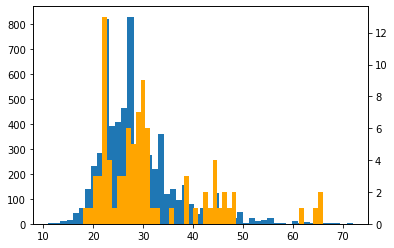

In [849]:
# threshold = 2
# _=plt.hist(sigsizes[sigvalue  < threshold],bins=50)
# plt.twinx()
# _=plt.hist(sigsizes[sigvalue >= threshold],bins=50, color='orange')

In [357]:
# limit = 500

# check = []
# where = []
# sampl = []
# snext = []
# sbegi = []
# sendi = []

# validity = {}
# for k in QRSon:
#     if k not in Toff: continue
#     deltaQRS = QRSon[k][1:]-QRSon[k][:-1]
#     first = int(min(np.hstack([Pon.get(k,[]),QRSon.get(k,[]),Ton.get(k,[])]))-20)
#     last = int(max(np.hstack([Poff.get(k,[]),QRSoff.get(k,[]),Toff.get(k,[])]))+20)
#     if max(deltaQRS) > limit:
#         check.append(k)
#         where.append(np.argwhere(deltaQRS > limit))
#         sampl.append(Toff[k][np.argwhere(deltaQRS > limit)])
#         snext.append(QRSon[k][np.argwhere(deltaQRS > limit)])
#         sbegi.append([first])
#         sendi.append([last])
        
#     validity[k] = [[first,last]]

# validity['sel231_0']   = [[150280,161620],[165900,171550]]
# validity['sel231_1']   = [[150280,161620],[165900,171550]]
# validity['sel213_0']   = [[150130,154000],[190830,196810]]
# validity['sel213_1']   = [[150130,154000],[190830,196810]]
# validity['sel301_0']   = [[150180,153380],[157000,159800]]
# validity['sel301_1']   = [[150180,153380],[157000,159800]]
# validity['sele0112_0'] = [[150410,160470],[207800,213850]]
# validity['sele0112_1'] = [[150410,160470],[207800,213850]]

# sak.save_data(validity,os.path.join(basedir,'QTDB','validity.csv'))

In [359]:
# i = 8
# k = check[i]
# s = int(sbegi[i][0])
# print(s)
# print(k)

# pon,poff     = src.metrics.filter_valid(Pon[k],Poff[k],s-2000,s+2000)
# qrson,qrsoff = src.metrics.filter_valid(QRSon[k],QRSoff[k],s-2000,s+2000)
# ton,toff     = src.metrics.filter_valid(Ton[k],Toff[k],s-2000,s+2000)

# plt.figure(figsize=(15,4))
# plt.plot(dataset[k][s-1000:s+1000])
# [plt.gca().axvspan(onset,offset, color='red', alpha=0.15) for (onset,offset) in zip(pon,poff)]
# [plt.gca().axvspan(onset,offset, color='green', alpha=0.15) for (onset,offset) in zip(qrson,qrsoff)]
# [plt.gca().axvspan(onset,offset, color='magenta', alpha=0.15) for (onset,offset) in zip(ton,toff)]
# # plt.gca().axvline(s-20,color='orange')
# plt.gca().axvline(s,color='red')
# plt.gca().axvline(150130,color='orange')
# plt.xlim([s-1000,s+1000])
# plt.show()

In [360]:
# # Plot validity
# f = plt.figure(figsize=(15,4))

# for k in tqdm.tqdm(validity):
#     on,off = validity[k][0]
#     if k in Pon:
#         pon,poff = src.metrics.filter_valid(Pon[k],Poff[k],on,off)
#     qrson,qrsoff = src.metrics.filter_valid(QRSon[k],QRSoff[k],on,off)
#     ton,toff     = src.metrics.filter_valid(Ton[k],Toff[k],on,off)
    
#     s = on
    
#     f.gca().plot(dataset[k][s-1000:s+1000])
#     if k in Pon:
#         [f.gca().axvspan(onset,offset, color='red', alpha=0.15) for (onset,offset) in zip(pon,poff)]
#     [f.gca().axvspan(onset,offset, color='green', alpha=0.15) for (onset,offset) in zip(qrson,qrsoff)]
#     [f.gca().axvspan(onset,offset, color='magenta', alpha=0.15) for (onset,offset) in zip(ton,toff)]
#     f.gca().axvline(s,color='red')
#     f.gca().set_xlim([s-1000,s+1000])
#     f.savefig(os.path.join('/home/guille/Escritorio/Valid/',k+'_first'))
#     f.gca().clear()
    
#     s = off

#     f.gca().plot(dataset[k][s-1000:s+1000])
#     if k in Pon:
#         [f.gca().axvspan(onset,offset, color='red', alpha=0.15) for (onset,offset) in zip(pon,poff)]
#     [f.gca().axvspan(onset,offset, color='green', alpha=0.15) for (onset,offset) in zip(qrson,qrsoff)]
#     [f.gca().axvspan(onset,offset, color='magenta', alpha=0.15) for (onset,offset) in zip(ton,toff)]
#     f.gca().axvline(s,color='red')
#     f.gca().set_xlim([s-1000,s+1000])
#     f.savefig(os.path.join('/home/guille/Escritorio/Valid/',k+'_last.png'))
#     f.gca().clear()
    